In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## 1. Data Collection

In [2]:
train_dir = '../input/titanic/train.csv'
train_data = pd.read_csv(train_dir)
train_data.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
483,484,1,3,"Turkula, Mrs. (Hedwig)",female,63.0,0,0,4134,9.5875,NaN,S
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
757,758,0,2,"Bailey, Mr. Percy Andrew",male,18.0,0,0,29108,11.5000,NaN,S
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6000,A16,C


### 1 - a) Acquiring Relevant Data

Passenger Id, Name, Ticket and Cabin Attributes were irrelevant so I dropped these.

In [3]:
train_data.drop(columns = ['PassengerId', 'Name', 'Cabin', 'Ticket'], inplace = True)

## 2. Data Cleaning & Preprocessing

### 2 - a) Handling missing values

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [5]:
train_data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

The Dataset has got null values so we will impute them with mode because they are categorical

In [6]:
null_indices = train_data[train_data.isnull().any(axis = 1)].index

train_data['Age'].fillna(train_data['Age'].mode()[0], inplace = True)
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace = True)

train_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [7]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Next, we will discover noises in data.

<Axes: >

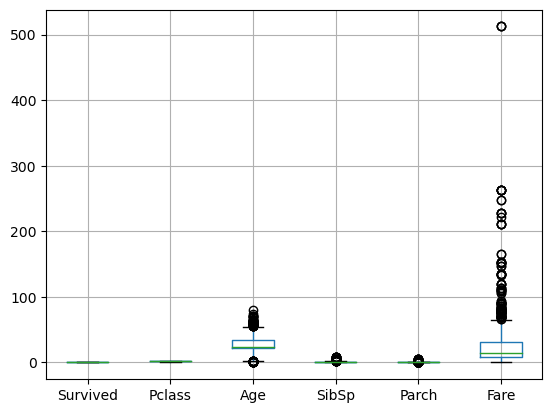

In [8]:
train_data.boxplot()

In [9]:
train_data[train_data.where(train_data['Fare'] > 500).notnull().any(axis = 1)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
258,1,1,female,35.0,0,0,512.3292,C
679,1,1,male,36.0,0,1,512.3292,C
737,1,1,male,35.0,0,0,512.3292,C


Over 500 in Fare may not be noises in data in spite of 1st class.

However, we will intentionally left the step of handling noises to see bad performance of models

## 4. Feature Engineering

We will intentionally left the step of normalization & scaling to see bad performance of models

### 4 - b) Transformations

In [10]:
train_data['Sex'], _ = train_data['Sex'].factorize()
encoder = OneHotEncoder(sparse = False)
OH_Embarked = pd.DataFrame(encoder.fit_transform(train_data[['Embarked']]), columns = train_data['Embarked'].unique())
train_data = pd.concat([train_data, OH_Embarked], axis = 1)
train_data.drop('Embarked', axis = 1, inplace = True)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 5. Model Selection & Training

### 5 - a) Split into train, test and valid

We had already split up valid and train so as to evaluate our model.

In [11]:
X_train = train_data.drop(columns = ['Survived'])
y_train = train_data['Survived']

X_train, X_valid, y_train, y_valid =train_test_split(X_train, y_train, test_size = 0.4)

X_valid.sample(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,S,C,Q
807,3,1,18.00,0,0,7.7750,0.0,0.0,1.0
33,2,0,66.00,0,0,10.5000,0.0,0.0,1.0
35,1,0,42.00,1,0,52.0000,0.0,0.0,1.0
755,2,0,0.67,1,1,14.5000,0.0,0.0,1.0
721,3,0,17.00,1,0,7.0542,0.0,0.0,1.0


We've set maximum iterations into 300 since data hasn't scaled.

In [12]:
model = LogisticRegression(max_iter = 300)
model.fit(X_train, y_train)

LogisticRegression(max_iter=300)

In [13]:
pred_train = model.predict(X_train)
accuracy_score(y_train, pred_train)

0.7790262172284644

In [14]:
pred_valid = model.predict(X_valid)
accuracy_score(y_valid, pred_valid)

0.8207282913165266